In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

## Import data

In [2]:
df = pd.read_csv('column_2C_weka.csv')

In [3]:
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [4]:
df.shape

(310, 7)

## EDA

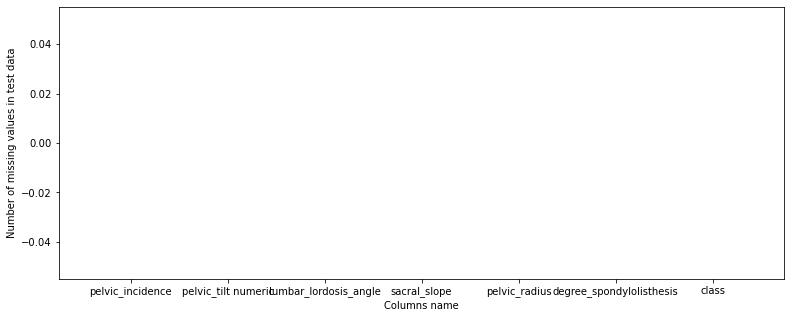

In [5]:
# Missing data in dataset
plt.figure(figsize = (13,5))
plt.bar(df.columns, df.isnull().sum().values, color = 'red')
plt.xlabel("Columns name")
plt.ylabel("Number of missing values in test data")
plt.show()

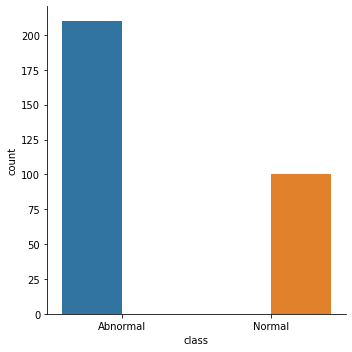

In [6]:
# Output data distribution
sns.catplot(x='class', hue='class', data=df, kind="count")

## Data preprocessing

In [7]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [8]:
Y = [1 if each == "Abnormal" else 0 for each in y]

In [9]:
scaler = MinMaxScaler()
scaler.fit(x)
X = scaler.transform(x)

## Divide into train/ val

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_val.shape)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)

print(Y_train.shape)
print(Y_val.shape)

(248, 6)
(62, 6)
(248,)
(62,)


## Models

### Neural network

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential

In [13]:
model_nn1 = Sequential([
    Input(shape=(6, )),
    Dense(units=20, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

In [14]:
model_nn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_nn1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer='adam',
)

In [16]:
model_nn1.fit(
    X_train, Y_train,
    epochs=100
)

Epoch 1/100
8/8 [==============================] - 1s 2ms/step - loss: 0.6831
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6742
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6648
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6536
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6432
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6326
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6246
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6172
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6105
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6067
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6014
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5980
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

### Decision forest

In [17]:
from xgboost import XGBClassifier

In [18]:
xgb_model = XGBClassifier(objective="binary:logistic")
xgb_model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Decision forest 2 (with hyperparameter tuning)

In [19]:
search_space = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.001, 0.005, 0.01]
}

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
GS = GridSearchCV(
    estimator=xgb_model,
    param_grid=search_space,
    scoring=["r2", "neg_root_mean_squared_error"],
    refit="r2",
    cv=5,
    verbose=4
)

In [22]:
GS.fit(X_train, Y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.374) r2: (test=0.357) total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.469) r2: (test=-0.011) total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.346) r2: (test=0.449) total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.515) r2: (test=-0.206) total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.404) r2: (test=0.258) total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=200; neg_root_mean_squared_error: (test=-0.424) r2: (test=0.173) total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=200; neg_roo

[CV 4/5] END learning_rate=0.005, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.474) r2: (test=-0.021) total time=   0.1s
[CV 5/5] END learning_rate=0.005, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.429) r2: (test=0.165) total time=   0.0s
[CV 1/5] END learning_rate=0.005, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.374) r2: (test=0.357) total time=   0.0s
[CV 2/5] END learning_rate=0.005, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.374) r2: (test=0.357) total time=   0.0s
[CV 3/5] END learning_rate=0.005, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.283) r2: (test=0.632) total time=   0.0s
[CV 4/5] END learning_rate=0.005, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.474) r2: (test=-0.021) total time=   0.0s
[CV 5/5] END learning_rate=0.005, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.429) r2: (test=0.165) total tim

[CV 4/5] END learning_rate=0.01, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.452) r2: (test=0.072) total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.429) r2: (test=0.165) total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.346) r2: (test=0.449) total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.374) r2: (test=0.357) total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.316) r2: (test=0.540) total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.474) r2: (test=-0.021) total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.429) r2: (test=0.165) total time=   0.0

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.001, 0.005, 0.01],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 500]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=4)

In [23]:
print(GS.best_score_)

0.29808377896613203


In [24]:
print(GS.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


In [25]:
xgb_model2 = XGBClassifier(objective="binary:logistic", learning_rate=0.01, max_depth=3, n_estimators=500)

In [26]:
xgb_model2.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Neural network 2 with hyperparameter tuning

In [27]:
def create_nn_model(neurons=1, neurons2=2, activation='relu'):
    nn = Sequential([
        Input(shape=(6, )),
        Dense(units = neurons, activation = activation),
        Dropout(0.1),
        Dense(units = neurons2, activation = activation),
        Dense(units = 1, activation="sigmoid")
    ])
    nn.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    return nn

In [28]:
from scikeras.wrappers import KerasClassifier

In [29]:
model_nn2 = KerasClassifier(build_fn=create_nn_model, epochs=[100, 200, 300], verbose=1, neurons=[16, 32, 64], neurons2=[8, 16, 32])

In [30]:
searchspace_2 = {
    'neurons': [16, 32],
    'neurons2': [8, 16],
    'batch_size': [32, 64],
    'epochs': [100, 200, 300]
}

In [31]:
GS2 = GridSearchCV(
    estimator=model_nn2,
    param_grid=searchspace_2,
    cv=3,
    n_jobs=1,
    verbose=0
)

In [32]:
model_nn2.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'neurons', 'neurons2', 'class_weight'])

In [33]:
GS2.fit(X_train, Y_train)

Epoch 1/100


/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 1s 4ms/step - loss: 0.7079 - accuracy: 0.3091
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.3515
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6958 - accuracy: 0.4000
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5818
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.6606
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.6667
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.6727
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 4ms/step - loss: 0.5209 - accuracy: 0.7091
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5033 - accuracy: 0.7273
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5016 - accuracy: 0.7455
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4994 - accuracy: 0.7091
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5126 - accuracy: 0.7212
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5028 - accuracy: 0.7394
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4947 - accuracy: 0.7394
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4979 - accuracy: 0.7212
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5019 - accuracy: 0.7455
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5011 - accuracy: 0.7333
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.6545
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.6667
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6653 - accuracy: 0.6727
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6054 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6003 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.4803 - accuracy: 0.7576
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4737 - accuracy: 0.7515
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4811 - accuracy: 0.7455
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4767 - accuracy: 0.7697
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4679 - accuracy: 0.7697
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4750 - accuracy: 0.7394
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4678 - accuracy: 0.7636
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7636
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4728 - accuracy: 0.7879
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.7697
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7545 - accuracy: 0.3373
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7276 - accuracy: 0.4458
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7095 - accuracy: 0.4096
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5181
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.5843
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6733 - accuracy: 0.6145
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6650 - accuracy: 0.6386
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6546 - accuracy: 0.6687
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6562 - accuracy: 0.6687
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6471 - accuracy: 0.6928
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.4869 - accuracy: 0.7530
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4808 - accuracy: 0.7651
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5000 - accuracy: 0.7289
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4802 - accuracy: 0.7771
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4925 - accuracy: 0.7470
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4819 - accuracy: 0.7651
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4763 - accuracy: 0.7530
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4900 - accuracy: 0.7651
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4621 - accuracy: 0.7771
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4722 - accuracy: 0.7590
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 1s 3ms/step - loss: 0.6700 - accuracy: 0.6970
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6498 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6380 - accuracy: 0.6848
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6224 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6030 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6028 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5950 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4202 - accuracy: 0.8485
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4290 - accuracy: 0.8182
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4191 - accuracy: 0.8424
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4361 - accuracy: 0.7879
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4195 - accuracy: 0.8000
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4123 - accuracy: 0.8364
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4378 - accuracy: 0.8121
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4363 - accuracy: 0.7879
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4189 - accuracy: 0.8061
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4281 - accuracy: 0.8242
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.4667
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.6303
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.6970
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6729 - accuracy: 0.6848
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6677 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6645 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6562 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6511 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6420 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.4207 - accuracy: 0.8182
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4105 - accuracy: 0.8061
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4258 - accuracy: 0.8061
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.7697
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4221 - accuracy: 0.8000
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4266 - accuracy: 0.8182
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.7879
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4381 - accuracy: 0.7697
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4008 - accuracy: 0.8000
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.7939
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.3795
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.4337
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5361
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.6687
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.6687
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6747
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6867
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6867
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6399 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4597 - accuracy: 0.7831
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4521 - accuracy: 0.8072
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4618 - accuracy: 0.7530
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4552 - accuracy: 0.7831
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4649 - accuracy: 0.7711
Epoch 89/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4469 - accuracy: 0.7530
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4331 - accuracy: 0.7711
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4481 - accuracy: 0.7952
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4403 - accuracy: 0.7651
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4394 - accuracy: 0.7771
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 1s 3ms/step - loss: 0.6852 - accuracy: 0.6424
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.6727
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6020 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4347 - accuracy: 0.8121
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4339 - accuracy: 0.7879
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4328 - accuracy: 0.7879
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4279 - accuracy: 0.8182
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4296 - accuracy: 0.8303
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4222 - accuracy: 0.8121
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4209 - accuracy: 0.8364
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4290 - accuracy: 0.8061
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.8061
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4274 - accuracy: 0.8121
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7394 - accuracy: 0.3152
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7193 - accuracy: 0.3576
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.4848
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5939
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.6424
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.6545
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.6727
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.6727
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.6727
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6727
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4886 - accuracy: 0.7273
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4975 - accuracy: 0.7273
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4872 - accuracy: 0.7394
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4877 - accuracy: 0.7273
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4884 - accuracy: 0.7394
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4807 - accuracy: 0.7758
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4889 - accuracy: 0.7455
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4765 - accuracy: 0.7636
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4900 - accuracy: 0.7455
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4854 - accuracy: 0.7515
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 4ms/step - loss: 0.7262 - accuracy: 0.3253
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.3133
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.3675
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.5723
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5542
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.6506
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.6265
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6736 - accuracy: 0.6566
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6660 - accuracy: 0.6807
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.6687
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.4816 - accuracy: 0.7530
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4657 - accuracy: 0.7590
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.7651
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4586 - accuracy: 0.7711
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4658 - accuracy: 0.7530
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4550 - accuracy: 0.7470
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4441 - accuracy: 0.7952
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.7771
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4553 - accuracy: 0.7892
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4653 - accuracy: 0.7349
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.6364
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6525 - accuracy: 0.6848
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6100 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6037 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5943 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4139 - accuracy: 0.8121
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4238 - accuracy: 0.8000
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4230 - accuracy: 0.8364
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4139 - accuracy: 0.8303
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4068 - accuracy: 0.8121
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4096 - accuracy: 0.8364
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4004 - accuracy: 0.8424
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4077 - accuracy: 0.8242
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4246 - accuracy: 0.8061
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4092 - accuracy: 0.8121
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.6606
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.6727
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6420 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6243 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4002 - accuracy: 0.7939
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3995 - accuracy: 0.8364
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3873 - accuracy: 0.8061
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3921 - accuracy: 0.8061
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3901 - accuracy: 0.8182
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3908 - accuracy: 0.8121
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3809 - accuracy: 0.8303
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4022 - accuracy: 0.8182
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3744 - accuracy: 0.8485
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3915 - accuracy: 0.7879
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.6687
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6602 - accuracy: 0.6687
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6747
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6747
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6328 - accuracy: 0.6747
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6747
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6160 - accuracy: 0.6747
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5977 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5896 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4038 - accuracy: 0.8434
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.8434
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3959 - accuracy: 0.8313
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4087 - accuracy: 0.8253
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4071 - accuracy: 0.8193
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3857 - accuracy: 0.8373
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4012 - accuracy: 0.8072
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3827 - accuracy: 0.8072
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3998 - accuracy: 0.8193
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.3973 - accuracy: 0.8253
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7499 - accuracy: 0.3394
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.3152
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.7220 - accuracy: 0.3333
Epoch 4/200
6/6 [==============================] - 0s 2ms/step - loss: 0.7064 - accuracy: 0.3515
Epoch 5/200
6/6 [==============================] - 0s 2ms/step - loss: 0.7034 - accuracy: 0.3939
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5091
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5939
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6545
Epoch 9/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6613 - accuracy: 0.6545
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6909
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4830 - accuracy: 0.7515
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4777 - accuracy: 0.7455
Epoch 86/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.7455
Epoch 87/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4598 - accuracy: 0.7879
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4784 - accuracy: 0.7697
Epoch 89/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.8000
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4684 - accuracy: 0.8182
Epoch 91/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.7879
Epoch 92/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4680 - accuracy: 0.7818
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4549 - accuracy: 0.8121
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.3732 - accuracy: 0.8364
Epoch 168/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3770 - accuracy: 0.8182
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3630 - accuracy: 0.8545
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3739 - accuracy: 0.8000
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3786 - accuracy: 0.8485
Epoch 172/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3632 - accuracy: 0.8424
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3790 - accuracy: 0.8606
Epoch 174/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3701 - accuracy: 0.8121
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3888 - accuracy: 0.8364
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3631 - accuracy: 0.8545
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.4545
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.6121
Epoch 3/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6817 - accuracy: 0.6364
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.6545
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6727
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.6667
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6788
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6788
Epoch 9/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6429 - accuracy: 0.6788
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6788
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5169 - accuracy: 0.7273
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5134 - accuracy: 0.7091
Epoch 86/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5099 - accuracy: 0.7455
Epoch 87/200
6/6 [==============================] - 0s 2ms/step - loss: 0.5121 - accuracy: 0.7455
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5117 - accuracy: 0.7576
Epoch 89/200
6/6 [==============================] - 0s 2ms/step - loss: 0.5114 - accuracy: 0.7394
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5190 - accuracy: 0.7455
Epoch 91/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4951 - accuracy: 0.7394
Epoch 92/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4993 - accuracy: 0.7394
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4992 - accuracy: 0.7273
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.4273 - accuracy: 0.7758
Epoch 168/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.7879
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4285 - accuracy: 0.7818
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4093 - accuracy: 0.8061
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4113 - accuracy: 0.8061
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4138 - accuracy: 0.8061
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4158 - accuracy: 0.8121
Epoch 174/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4298 - accuracy: 0.7879
Epoch 175/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4006 - accuracy: 0.8182
Epoch 176/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.7879
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.6205
Epoch 2/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6888 - accuracy: 0.6687
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.6627
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.6687
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.6687
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.6747
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.6747
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.6747
Epoch 9/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.6747
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.6747
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4942 - accuracy: 0.7229
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4843 - accuracy: 0.7530
Epoch 86/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4826 - accuracy: 0.7470
Epoch 87/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4870 - accuracy: 0.7590
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4893 - accuracy: 0.7410
Epoch 89/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4754 - accuracy: 0.7349
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4803 - accuracy: 0.7470
Epoch 91/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4996 - accuracy: 0.7470
Epoch 92/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4730 - accuracy: 0.7530
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4818 - accuracy: 0.7108
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.4279 - accuracy: 0.8072
Epoch 168/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.7952
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4270 - accuracy: 0.8072
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4435 - accuracy: 0.7470
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4243 - accuracy: 0.8133
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4492 - accuracy: 0.7771
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4387 - accuracy: 0.7892
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4358 - accuracy: 0.8072
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4281 - accuracy: 0.7892
Epoch 176/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4543 - accuracy: 0.7831
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6042 - accuracy: 0.6788
Epoch 2/200
6/6 [==============================] - 0s 2ms/step - loss: 0.5970 - accuracy: 0.6788
Epoch 3/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6076 - accuracy: 0.6788
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6010 - accuracy: 0.6788
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5949 - accuracy: 0.6788
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5845 - accuracy: 0.6788
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5953 - accuracy: 0.6788
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5857 - accuracy: 0.6788
Epoch 9/200
6/6 [==============================] - 0s 4ms/step - loss: 0.5819 - accuracy: 0.6788
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5750 - accuracy: 0.6788
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4335 - accuracy: 0.8000
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4307 - accuracy: 0.8061
Epoch 86/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4380 - accuracy: 0.8242
Epoch 87/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4349 - accuracy: 0.8182
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4204 - accuracy: 0.8303
Epoch 89/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4134 - accuracy: 0.8061
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4248 - accuracy: 0.7818
Epoch 91/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4383 - accuracy: 0.7879
Epoch 92/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4370 - accuracy: 0.7758
Epoch 93/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.8182
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3515 - accuracy: 0.8485
Epoch 168/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3453 - accuracy: 0.8485
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3328 - accuracy: 0.8606
Epoch 170/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3392 - accuracy: 0.8364
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3325 - accuracy: 0.8606
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3438 - accuracy: 0.8424
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3378 - accuracy: 0.8545
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3122 - accuracy: 0.8667
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3634 - accuracy: 0.8424
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3583 - accuracy: 0.8303
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 1s 3ms/step - loss: 0.6492 - accuracy: 0.6364
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6606
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6606
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6788
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6727
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6788
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6788
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6788
Epoch 9/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6156 - accuracy: 0.6788
Epoch 10/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.6788
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.4405 - accuracy: 0.8121
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4517 - accuracy: 0.7818
Epoch 86/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4540 - accuracy: 0.7758
Epoch 87/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4538 - accuracy: 0.8121
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4514 - accuracy: 0.7697
Epoch 89/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.8242
Epoch 90/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4306 - accuracy: 0.7818
Epoch 91/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4284 - accuracy: 0.7939
Epoch 92/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4336 - accuracy: 0.7818
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4409 - accuracy: 0.8121
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.8364
Epoch 168/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3392 - accuracy: 0.8424
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3409 - accuracy: 0.8606
Epoch 170/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3487 - accuracy: 0.8545
Epoch 171/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3350 - accuracy: 0.8545
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3497 - accuracy: 0.8424
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3539 - accuracy: 0.8667
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3690 - accuracy: 0.8485
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3405 - accuracy: 0.8545
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3427 - accuracy: 0.8364
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7226 - accuracy: 0.3253
Epoch 2/200
6/6 [==============================] - 0s 2ms/step - loss: 0.7122 - accuracy: 0.3193
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.3614
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.3675
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5602
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.6325
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.6627
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.6747
Epoch 9/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.6747
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.6747
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4657 - accuracy: 0.7590
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4551 - accuracy: 0.7892
Epoch 86/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4465 - accuracy: 0.7831
Epoch 87/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.7831
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4644 - accuracy: 0.7711
Epoch 89/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4489 - accuracy: 0.7831
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4633 - accuracy: 0.7711
Epoch 91/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4642 - accuracy: 0.7892
Epoch 92/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4534 - accuracy: 0.8012
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4574 - accuracy: 0.7590
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3837 - accuracy: 0.8072
Epoch 168/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3861 - accuracy: 0.7831
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3876 - accuracy: 0.8313
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4062 - accuracy: 0.8253
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3826 - accuracy: 0.8193
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3914 - accuracy: 0.8313
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3594 - accuracy: 0.8554
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3586 - accuracy: 0.8494
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3748 - accuracy: 0.8313
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3624 - accuracy: 0.8434
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6909
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6788
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6788
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6788
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6788
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.6788
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6788
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6043 - accuracy: 0.6788
Epoch 9/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6004 - accuracy: 0.6788
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.6788
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4165 - accuracy: 0.7879
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4122 - accuracy: 0.8303
Epoch 86/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4238 - accuracy: 0.8000
Epoch 87/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4084 - accuracy: 0.8242
Epoch 88/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4066 - accuracy: 0.8061
Epoch 89/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4125 - accuracy: 0.8303
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4119 - accuracy: 0.8303
Epoch 91/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3992 - accuracy: 0.8364
Epoch 92/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4037 - accuracy: 0.8121
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4048 - accuracy: 0.8182
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.3254 - accuracy: 0.8424
Epoch 168/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3176 - accuracy: 0.8485
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3134 - accuracy: 0.8727
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3028 - accuracy: 0.8545
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3132 - accuracy: 0.8667
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3055 - accuracy: 0.8606
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3092 - accuracy: 0.8485
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3052 - accuracy: 0.8727
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3097 - accuracy: 0.8727
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3073 - accuracy: 0.8485
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.3515
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5273
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.6545
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.7030
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6970
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.7030
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.7030
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6970
Epoch 9/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6909
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6788
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4595 - accuracy: 0.7697
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4317 - accuracy: 0.7758
Epoch 86/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4647 - accuracy: 0.7455
Epoch 87/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4353 - accuracy: 0.8000
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.8242
Epoch 89/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.7818
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4426 - accuracy: 0.7818
Epoch 91/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4325 - accuracy: 0.7818
Epoch 92/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4186 - accuracy: 0.8000
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4370 - accuracy: 0.8061
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3355 - accuracy: 0.8424
Epoch 168/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3246 - accuracy: 0.8545
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3173 - accuracy: 0.8606
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3182 - accuracy: 0.8848
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3113 - accuracy: 0.8606
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3276 - accuracy: 0.8485
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3305 - accuracy: 0.8667
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3264 - accuracy: 0.8727
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3210 - accuracy: 0.8545
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3287 - accuracy: 0.8545
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7273 - accuracy: 0.2711
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.3072
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.2831
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4036
Epoch 5/200
6/6 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5542
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.6265
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.6687
Epoch 8/200
6/6 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.6747
Epoch 9/200
6/6 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.6747
Epoch 10/200
6/6 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.7048
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4535 - accuracy: 0.7831
Epoch 85/200
6/6 [==============================] - 0s 4ms/step - loss: 0.4595 - accuracy: 0.7831
Epoch 86/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4561 - accuracy: 0.7892
Epoch 87/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4572 - accuracy: 0.7892
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4522 - accuracy: 0.8012
Epoch 89/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4515 - accuracy: 0.7952
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.7952
Epoch 91/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4486 - accuracy: 0.8012
Epoch 92/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4361 - accuracy: 0.7831
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4494 - accuracy: 0.7711
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3970 - accuracy: 0.8494
Epoch 168/200
6/6 [==============================] - 0s 4ms/step - loss: 0.3856 - accuracy: 0.8494
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3866 - accuracy: 0.8434
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3848 - accuracy: 0.8614
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3814 - accuracy: 0.8193
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3861 - accuracy: 0.8133
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3915 - accuracy: 0.8313
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3808 - accuracy: 0.8193
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3812 - accuracy: 0.8253
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3673 - accuracy: 0.8434
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.3636
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5636
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6727
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6652 - accuracy: 0.6727
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6788
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6788
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6788
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6788
Epoch 9/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6788
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.6788
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.3426 - accuracy: 0.8545
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3403 - accuracy: 0.8788
Epoch 86/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3311 - accuracy: 0.8606
Epoch 87/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3493 - accuracy: 0.8545
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3711 - accuracy: 0.8182
Epoch 89/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3518 - accuracy: 0.8303
Epoch 90/200
6/6 [==============================] - 0s 4ms/step - loss: 0.3556 - accuracy: 0.8485
Epoch 91/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3465 - accuracy: 0.8424
Epoch 92/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3337 - accuracy: 0.8788
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3524 - accuracy: 0.8364
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.2630 - accuracy: 0.8788
Epoch 168/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2723 - accuracy: 0.8727
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2764 - accuracy: 0.8727
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2777 - accuracy: 0.8485
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2597 - accuracy: 0.8848
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2742 - accuracy: 0.8667
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2555 - accuracy: 0.8788
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2811 - accuracy: 0.8848
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2725 - accuracy: 0.8788
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2903 - accuracy: 0.8606
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.6545
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6970
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6788
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6788
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6788
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6126 - accuracy: 0.6788
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6056 - accuracy: 0.6788
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5959 - accuracy: 0.6788
Epoch 9/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5915 - accuracy: 0.6788
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5848 - accuracy: 0.6788
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4021 - accuracy: 0.8182
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4039 - accuracy: 0.7879
Epoch 86/200
6/6 [==============================] - 0s 2ms/step - loss: 0.4021 - accuracy: 0.8545
Epoch 87/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3848 - accuracy: 0.8242
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3782 - accuracy: 0.8242
Epoch 89/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3801 - accuracy: 0.8182
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3734 - accuracy: 0.8545
Epoch 91/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3848 - accuracy: 0.8242
Epoch 92/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3665 - accuracy: 0.8364
Epoch 93/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3792 - accuracy: 0.8424
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.2881 - accuracy: 0.8667
Epoch 168/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2786 - accuracy: 0.8788
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2877 - accuracy: 0.8909
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2892 - accuracy: 0.8788
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2989 - accuracy: 0.8727
Epoch 172/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2872 - accuracy: 0.8788
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2803 - accuracy: 0.8909
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2850 - accuracy: 0.8970
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.2811 - accuracy: 0.8727
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3011 - accuracy: 0.8848
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6747
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6747
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6747
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.6747
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.6747
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.6747
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5999 - accuracy: 0.6747
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5977 - accuracy: 0.6747
Epoch 9/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5962 - accuracy: 0.6747
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5832 - accuracy: 0.6747
Epoch 11/200
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4121 - accuracy: 0.8253
Epoch 85/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4020 - accuracy: 0.8373
Epoch 86/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4054 - accuracy: 0.8434
Epoch 87/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4095 - accuracy: 0.8253
Epoch 88/200
6/6 [==============================] - 0s 3ms/step - loss: 0.4076 - accuracy: 0.8193
Epoch 89/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3934 - accuracy: 0.8072
Epoch 90/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3938 - accuracy: 0.8133
Epoch 91/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3862 - accuracy: 0.8313
Epoch 92/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3892 - accuracy: 0.8373
Epoch 93/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3920 - accuracy: 0.8253
Epoch 94/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 0.3234 - accuracy: 0.8434
Epoch 168/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3239 - accuracy: 0.8373
Epoch 169/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3269 - accuracy: 0.8434
Epoch 170/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3156 - accuracy: 0.8133
Epoch 171/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.8675
Epoch 172/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3246 - accuracy: 0.8253
Epoch 173/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3203 - accuracy: 0.8554
Epoch 174/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3291 - accuracy: 0.8554
Epoch 175/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3288 - accuracy: 0.8373
Epoch 176/200
6/6 [==============================] - 0s 3ms/step - loss: 0.3163 - accuracy: 0.8675
Epoch 177/200
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7527 - accuracy: 0.3576
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7238 - accuracy: 0.3939
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5636
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6727
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6848
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6303
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6193 - accuracy: 0.6788
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6060 - accuracy: 0.6788
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6788
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.6788
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4790 - accuracy: 0.7939
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4691 - accuracy: 0.8000
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4810 - accuracy: 0.7636
Epoch 87/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4752 - accuracy: 0.7818
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4623 - accuracy: 0.7939
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4776 - accuracy: 0.7818
Epoch 90/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4778 - accuracy: 0.7515
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4611 - accuracy: 0.8121
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4667 - accuracy: 0.7576
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4602 - accuracy: 0.8000
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3977 - accuracy: 0.8242
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4229 - accuracy: 0.8182
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4183 - accuracy: 0.7939
Epoch 170/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3948 - accuracy: 0.8242
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4055 - accuracy: 0.8242
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4053 - accuracy: 0.7939
Epoch 173/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3932 - accuracy: 0.8303
Epoch 174/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4074 - accuracy: 0.8061
Epoch 175/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4106 - accuracy: 0.8121
Epoch 176/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4075 - accuracy: 0.8121
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.3344 - accuracy: 0.8364
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3475 - accuracy: 0.8364
Epoch 251/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3402 - accuracy: 0.8364
Epoch 252/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3344 - accuracy: 0.8667
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3381 - accuracy: 0.8545
Epoch 254/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3242 - accuracy: 0.8424
Epoch 255/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3365 - accuracy: 0.8485
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3529 - accuracy: 0.8545
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3477 - accuracy: 0.8545
Epoch 258/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3568 - accuracy: 0.8485
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.8176 - accuracy: 0.3212
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7897 - accuracy: 0.3152
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7607 - accuracy: 0.3333
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7427 - accuracy: 0.2970
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.4000
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.4667
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5576
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.6667
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6788
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6788
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4863 - accuracy: 0.7455
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4753 - accuracy: 0.7758
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4846 - accuracy: 0.7515
Epoch 87/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4946 - accuracy: 0.7758
Epoch 88/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4737 - accuracy: 0.7697
Epoch 89/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.8000
Epoch 90/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4856 - accuracy: 0.7394
Epoch 91/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4697 - accuracy: 0.7939
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4916 - accuracy: 0.7455
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4902 - accuracy: 0.7394
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3767 - accuracy: 0.8303
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3702 - accuracy: 0.8364
Epoch 169/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3897 - accuracy: 0.8424
Epoch 170/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3859 - accuracy: 0.8061
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3758 - accuracy: 0.8242
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3916 - accuracy: 0.7939
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3767 - accuracy: 0.8424
Epoch 174/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3785 - accuracy: 0.8061
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3761 - accuracy: 0.8303
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3889 - accuracy: 0.8364
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 2ms/step - loss: 0.3110 - accuracy: 0.8727
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3602 - accuracy: 0.8364
Epoch 251/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3198 - accuracy: 0.8727
Epoch 252/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3352 - accuracy: 0.8303
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3177 - accuracy: 0.8364
Epoch 254/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3319 - accuracy: 0.8485
Epoch 255/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3085 - accuracy: 0.8667
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3443 - accuracy: 0.8364
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3031 - accuracy: 0.8848
Epoch 258/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3339 - accuracy: 0.8424
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.3434
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.3976
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5482
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.6265
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.6446
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.6747
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.6747
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.6747
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6747
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6747
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4744 - accuracy: 0.7590
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4753 - accuracy: 0.7349
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4730 - accuracy: 0.7711
Epoch 87/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4695 - accuracy: 0.7771
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4766 - accuracy: 0.7711
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4777 - accuracy: 0.7530
Epoch 90/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4572 - accuracy: 0.7470
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4856 - accuracy: 0.7470
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4762 - accuracy: 0.7410
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4662 - accuracy: 0.7771
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.4161 - accuracy: 0.7771
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4227 - accuracy: 0.7831
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4153 - accuracy: 0.8072
Epoch 170/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4240 - accuracy: 0.7952
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4270 - accuracy: 0.8012
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4119 - accuracy: 0.8253
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4073 - accuracy: 0.8133
Epoch 174/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4236 - accuracy: 0.7892
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4280 - accuracy: 0.8012
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4203 - accuracy: 0.8373
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.3794 - accuracy: 0.8373
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3766 - accuracy: 0.8313
Epoch 251/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3896 - accuracy: 0.8133
Epoch 252/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3854 - accuracy: 0.8193
Epoch 253/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3688 - accuracy: 0.8133
Epoch 254/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3676 - accuracy: 0.8554
Epoch 255/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3753 - accuracy: 0.8434
Epoch 256/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3722 - accuracy: 0.8434
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3654 - accuracy: 0.8253
Epoch 258/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3588 - accuracy: 0.8434
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7250 - accuracy: 0.3394
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.4485
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.5758
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6606
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6788
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6788
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6788
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6076 - accuracy: 0.6788
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6024 - accuracy: 0.6788
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.5962 - accuracy: 0.6788
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4370 - accuracy: 0.8121
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4475 - accuracy: 0.7636
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4398 - accuracy: 0.7697
Epoch 87/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4343 - accuracy: 0.8242
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4293 - accuracy: 0.8000
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4224 - accuracy: 0.7879
Epoch 90/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4286 - accuracy: 0.8000
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.8303
Epoch 92/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4340 - accuracy: 0.8000
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4312 - accuracy: 0.8061
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3546 - accuracy: 0.8485
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3489 - accuracy: 0.8364
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3508 - accuracy: 0.8303
Epoch 170/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3877 - accuracy: 0.8061
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3516 - accuracy: 0.8485
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3528 - accuracy: 0.8606
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3700 - accuracy: 0.8242
Epoch 174/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.8485
Epoch 175/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3479 - accuracy: 0.8242
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3415 - accuracy: 0.8424
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.3163 - accuracy: 0.8727
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3219 - accuracy: 0.8545
Epoch 251/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3189 - accuracy: 0.8545
Epoch 252/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2933 - accuracy: 0.8788
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2891 - accuracy: 0.8788
Epoch 254/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2941 - accuracy: 0.8606
Epoch 255/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3219 - accuracy: 0.8424
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3250 - accuracy: 0.8545
Epoch 257/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2959 - accuracy: 0.8545
Epoch 258/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3321 - accuracy: 0.8545
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 1s 3ms/step - loss: 0.7243 - accuracy: 0.3333
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.3455
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5576
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.6727
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6667
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6788
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6788
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6788
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6788
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.6788
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4654 - accuracy: 0.7758
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4630 - accuracy: 0.7455
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4711 - accuracy: 0.7515
Epoch 87/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4621 - accuracy: 0.7576
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4731 - accuracy: 0.7697
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4764 - accuracy: 0.7455
Epoch 90/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4700 - accuracy: 0.7697
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.7636
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4674 - accuracy: 0.7758
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4711 - accuracy: 0.7576
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3838 - accuracy: 0.8485
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.8485
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3696 - accuracy: 0.8545
Epoch 170/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3910 - accuracy: 0.8303
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3860 - accuracy: 0.8424
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3719 - accuracy: 0.8303
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3871 - accuracy: 0.8000
Epoch 174/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3385 - accuracy: 0.8667
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3922 - accuracy: 0.8303
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3756 - accuracy: 0.8303
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.3512 - accuracy: 0.8242
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3035 - accuracy: 0.8970
Epoch 251/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3067 - accuracy: 0.8909
Epoch 252/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2975 - accuracy: 0.8788
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3090 - accuracy: 0.8606
Epoch 254/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3161 - accuracy: 0.8788
Epoch 255/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3099 - accuracy: 0.8848
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3100 - accuracy: 0.8545
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2856 - accuracy: 0.8727
Epoch 258/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3183 - accuracy: 0.8667
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7332 - accuracy: 0.3253
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7241 - accuracy: 0.3253
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.3795
Epoch 4/300
6/6 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.4578
Epoch 5/300
6/6 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5241
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5904
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.6988
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6747
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6687
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6747
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4449 - accuracy: 0.7892
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4468 - accuracy: 0.7831
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4379 - accuracy: 0.8012
Epoch 87/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4535 - accuracy: 0.8193
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4408 - accuracy: 0.8012
Epoch 89/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4380 - accuracy: 0.7711
Epoch 90/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.7892
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4472 - accuracy: 0.8133
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4498 - accuracy: 0.7831
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4705 - accuracy: 0.7530
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3639 - accuracy: 0.8253
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3927 - accuracy: 0.8193
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3851 - accuracy: 0.8253
Epoch 170/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3699 - accuracy: 0.8133
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3809 - accuracy: 0.8554
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3596 - accuracy: 0.8133
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3759 - accuracy: 0.8313
Epoch 174/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3729 - accuracy: 0.8494
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3882 - accuracy: 0.7952
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3492 - accuracy: 0.8554
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.8675
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3081 - accuracy: 0.8735
Epoch 251/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3371 - accuracy: 0.8434
Epoch 252/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3245 - accuracy: 0.8554
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3405 - accuracy: 0.8434
Epoch 254/300
6/6 [==============================] - 0s 4ms/step - loss: 0.3296 - accuracy: 0.8434
Epoch 255/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3348 - accuracy: 0.8373
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3608 - accuracy: 0.8373
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3228 - accuracy: 0.8614
Epoch 258/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3091 - accuracy: 0.8795
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.6061
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.6667
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6727
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6788
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6788
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6788
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6788
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6167 - accuracy: 0.6788
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6077 - accuracy: 0.6788
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6062 - accuracy: 0.6788
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4239 - accuracy: 0.8485
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4178 - accuracy: 0.7939
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4039 - accuracy: 0.8182
Epoch 87/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4080 - accuracy: 0.7939
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4096 - accuracy: 0.8182
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4089 - accuracy: 0.8061
Epoch 90/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4038 - accuracy: 0.8364
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4057 - accuracy: 0.8061
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4061 - accuracy: 0.8303
Epoch 93/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4148 - accuracy: 0.8000
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3116 - accuracy: 0.8424
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3091 - accuracy: 0.8727
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3320 - accuracy: 0.8303
Epoch 170/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3180 - accuracy: 0.8545
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3165 - accuracy: 0.8485
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2889 - accuracy: 0.8727
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3077 - accuracy: 0.8848
Epoch 174/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3199 - accuracy: 0.8303
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3175 - accuracy: 0.8485
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2947 - accuracy: 0.8727
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.2788 - accuracy: 0.8848
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2588 - accuracy: 0.8788
Epoch 251/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2935 - accuracy: 0.8606
Epoch 252/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2762 - accuracy: 0.8545
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2902 - accuracy: 0.8364
Epoch 254/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.8788
Epoch 255/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2720 - accuracy: 0.8788
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2804 - accuracy: 0.8606
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2789 - accuracy: 0.8485
Epoch 258/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3120 - accuracy: 0.8545
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5515
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.6424
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6606
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6788
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6788
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6788
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6788
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6205 - accuracy: 0.6788
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6788
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6102 - accuracy: 0.6788
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.7515
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4667 - accuracy: 0.7697
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4637 - accuracy: 0.7818
Epoch 87/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4617 - accuracy: 0.7758
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4646 - accuracy: 0.7697
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4588 - accuracy: 0.7758
Epoch 90/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4474 - accuracy: 0.7939
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4565 - accuracy: 0.7758
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4397 - accuracy: 0.7939
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4519 - accuracy: 0.7576
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3470 - accuracy: 0.8848
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3494 - accuracy: 0.8667
Epoch 169/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.8545
Epoch 170/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3405 - accuracy: 0.8727
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3510 - accuracy: 0.8727
Epoch 172/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3440 - accuracy: 0.8606
Epoch 173/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3490 - accuracy: 0.8606
Epoch 174/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3378 - accuracy: 0.8848
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3367 - accuracy: 0.8545
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3212 - accuracy: 0.8727
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.2844 - accuracy: 0.8788
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2933 - accuracy: 0.8606
Epoch 251/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2979 - accuracy: 0.8667
Epoch 252/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2791 - accuracy: 0.8909
Epoch 253/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.8909
Epoch 254/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2887 - accuracy: 0.8788
Epoch 255/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2943 - accuracy: 0.8909
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2860 - accuracy: 0.8788
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2828 - accuracy: 0.8788
Epoch 258/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2987 - accuracy: 0.8909
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.3494
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.4880
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.6747
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.6747
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.6747
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6747
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6747
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6747
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6747
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6747
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4346 - accuracy: 0.8193
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4355 - accuracy: 0.8072
Epoch 86/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4386 - accuracy: 0.8133
Epoch 87/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4440 - accuracy: 0.8072
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4304 - accuracy: 0.8253
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4413 - accuracy: 0.7952
Epoch 90/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.8012
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4411 - accuracy: 0.7892
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4292 - accuracy: 0.7952
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4345 - accuracy: 0.7952
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3560 - accuracy: 0.8313
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3552 - accuracy: 0.8133
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3556 - accuracy: 0.8193
Epoch 170/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3669 - accuracy: 0.8313
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3578 - accuracy: 0.8434
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3545 - accuracy: 0.8434
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3560 - accuracy: 0.8434
Epoch 174/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3665 - accuracy: 0.8072
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3549 - accuracy: 0.8373
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3611 - accuracy: 0.8313
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 2ms/step - loss: 0.3077 - accuracy: 0.8554
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3316 - accuracy: 0.8253
Epoch 251/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3222 - accuracy: 0.8434
Epoch 252/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3304 - accuracy: 0.8313
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3336 - accuracy: 0.8554
Epoch 254/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3129 - accuracy: 0.8614
Epoch 255/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3189 - accuracy: 0.8313
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2980 - accuracy: 0.8795
Epoch 257/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3231 - accuracy: 0.8253
Epoch 258/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3182 - accuracy: 0.8554
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5030
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.6303
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.6667
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6788
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6788
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6788
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6788
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6788
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6788
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6174 - accuracy: 0.6788
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4154 - accuracy: 0.8303
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4191 - accuracy: 0.8000
Epoch 86/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4129 - accuracy: 0.8061
Epoch 87/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4236 - accuracy: 0.8061
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4184 - accuracy: 0.8061
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4193 - accuracy: 0.8242
Epoch 90/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.7879
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4151 - accuracy: 0.8121
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4145 - accuracy: 0.7879
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4105 - accuracy: 0.8364
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3374 - accuracy: 0.8545
Epoch 168/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3540 - accuracy: 0.8424
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3314 - accuracy: 0.8545
Epoch 170/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3102 - accuracy: 0.8727
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3407 - accuracy: 0.8485
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3398 - accuracy: 0.8485
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3440 - accuracy: 0.8364
Epoch 174/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3161 - accuracy: 0.8485
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3236 - accuracy: 0.8667
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3224 - accuracy: 0.8424
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 2ms/step - loss: 0.2844 - accuracy: 0.8788
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2957 - accuracy: 0.8727
Epoch 251/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2891 - accuracy: 0.8667
Epoch 252/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2911 - accuracy: 0.8424
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2844 - accuracy: 0.8788
Epoch 254/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2891 - accuracy: 0.8788
Epoch 255/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2967 - accuracy: 0.8727
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2945 - accuracy: 0.8667
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3016 - accuracy: 0.8485
Epoch 258/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2881 - accuracy: 0.8606
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7334 - accuracy: 0.3212
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.3212
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.3758
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5212
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.6182
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.6667
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6788
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6788
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6788
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6788
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4417 - accuracy: 0.8061
Epoch 85/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4547 - accuracy: 0.7576
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4454 - accuracy: 0.8061
Epoch 87/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4568 - accuracy: 0.7636
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4505 - accuracy: 0.7818
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4355 - accuracy: 0.8061
Epoch 90/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4261 - accuracy: 0.8182
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4348 - accuracy: 0.8061
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4334 - accuracy: 0.7939
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4390 - accuracy: 0.7879
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3378 - accuracy: 0.8485
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3370 - accuracy: 0.8545
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3463 - accuracy: 0.8667
Epoch 170/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3357 - accuracy: 0.8727
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3371 - accuracy: 0.8606
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3428 - accuracy: 0.8364
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3145 - accuracy: 0.8788
Epoch 174/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3399 - accuracy: 0.8424
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3492 - accuracy: 0.8545
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3386 - accuracy: 0.8545
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.3058 - accuracy: 0.8727
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2885 - accuracy: 0.8848
Epoch 251/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3045 - accuracy: 0.8667
Epoch 252/300
6/6 [==============================] - 0s 2ms/step - loss: 0.2919 - accuracy: 0.8909
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2919 - accuracy: 0.8667
Epoch 254/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2940 - accuracy: 0.8788
Epoch 255/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3068 - accuracy: 0.8606
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2950 - accuracy: 0.8909
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.2928 - accuracy: 0.8970
Epoch 258/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3066 - accuracy: 0.8909
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.4699
Epoch 2/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.6687
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6747
Epoch 4/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6747
Epoch 5/300
6/6 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.6747
Epoch 6/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6747
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6747
Epoch 8/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6747
Epoch 9/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6747
Epoch 10/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6107 - accuracy: 0.6747
Epoch 11/300
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4365 - accuracy: 0.8193
Epoch 85/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4425 - accuracy: 0.8253
Epoch 86/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4296 - accuracy: 0.7952
Epoch 87/300
6/6 [==============================] - 0s 2ms/step - loss: 0.4291 - accuracy: 0.8133
Epoch 88/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4240 - accuracy: 0.8193
Epoch 89/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.7831
Epoch 90/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4378 - accuracy: 0.8313
Epoch 91/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4338 - accuracy: 0.8373
Epoch 92/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4252 - accuracy: 0.8253
Epoch 93/300
6/6 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.8072
Epoch 94/300
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3564 - accuracy: 0.8614
Epoch 168/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3457 - accuracy: 0.8554
Epoch 169/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3622 - accuracy: 0.8313
Epoch 170/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3441 - accuracy: 0.8554
Epoch 171/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3606 - accuracy: 0.8193
Epoch 172/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3375 - accuracy: 0.8675
Epoch 173/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3520 - accuracy: 0.8554
Epoch 174/300
6/6 [==============================] - 0s 2ms/step - loss: 0.3472 - accuracy: 0.8554
Epoch 175/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3661 - accuracy: 0.8373
Epoch 176/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3450 - accuracy: 0.8434
Epoch 177/300
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 0.3114 - accuracy: 0.8735
Epoch 250/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3293 - accuracy: 0.8434
Epoch 251/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3081 - accuracy: 0.8434
Epoch 252/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3081 - accuracy: 0.8614
Epoch 253/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3150 - accuracy: 0.8494
Epoch 254/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3101 - accuracy: 0.8434
Epoch 255/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3446 - accuracy: 0.8253
Epoch 256/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3087 - accuracy: 0.8313
Epoch 257/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3005 - accuracy: 0.8494
Epoch 258/300
6/6 [==============================] - 0s 3ms/step - loss: 0.3039 - accuracy: 0.8494
Epoch 259/300
6/6 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7193 - accuracy: 0.3152
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.3152
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.3273
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.3212
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.3758
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.4303
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5152
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.6121
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.6182
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.6848
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4744 - accuracy: 0.7879
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4903 - accuracy: 0.7636
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4859 - accuracy: 0.7758
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4911 - accuracy: 0.7636
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4838 - accuracy: 0.7818
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4883 - accuracy: 0.7879
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5001 - accuracy: 0.7515
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4873 - accuracy: 0.7697
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4821 - accuracy: 0.7879
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5009 - accuracy: 0.7515
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7551 - accuracy: 0.3273
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7469 - accuracy: 0.3455
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7372 - accuracy: 0.3394
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7303 - accuracy: 0.3758
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.3697
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.3879
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7010 - accuracy: 0.4545
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5212
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5576
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.6061
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5755 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5800 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5702 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5659 - accuracy: 0.6848
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5762 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5873 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5675 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5736 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5616 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5742 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.4940
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5904
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.5422
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.6145
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.6265
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6386
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6687
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6627
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6807
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.5229 - accuracy: 0.6867
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5213 - accuracy: 0.6867
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5212 - accuracy: 0.6867
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5200 - accuracy: 0.6988
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5192 - accuracy: 0.6988
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5184 - accuracy: 0.7048
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5053 - accuracy: 0.7048
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4999 - accuracy: 0.7048
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5137 - accuracy: 0.6988
Epoch 93/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5082 - accuracy: 0.7289
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 1s 4ms/step - loss: 0.7165 - accuracy: 0.3212
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.3333
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.3515
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6999 - accuracy: 0.4242
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.4182
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5818
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.6727
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.6727
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.6727
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.6727
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5799 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5744 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5681 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5682 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5639 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5716 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5694 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5705 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5673 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5587 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.6606
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5390 - accuracy: 0.6848
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5334 - accuracy: 0.6727
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5482 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5447 - accuracy: 0.6727
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5394 - accuracy: 0.6970
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5482 - accuracy: 0.6909
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5258 - accuracy: 0.6727
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5399 - accuracy: 0.6970
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5343 - accuracy: 0.6970
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.6747
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6731 - accuracy: 0.6747
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6747
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6747
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6747
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4806 - accuracy: 0.7651
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4746 - accuracy: 0.7771
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4819 - accuracy: 0.8012
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4801 - accuracy: 0.7771
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4815 - accuracy: 0.7892
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4575 - accuracy: 0.8133
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4714 - accuracy: 0.7952
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4778 - accuracy: 0.7349
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4645 - accuracy: 0.7952
Epoch 93/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4605 - accuracy: 0.7771
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6788
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6083 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5981 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5948 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6031 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5975 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5952 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4684 - accuracy: 0.7758
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4382 - accuracy: 0.7818
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4548 - accuracy: 0.7818
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4497 - accuracy: 0.8061
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4430 - accuracy: 0.7758
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4459 - accuracy: 0.8121
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4406 - accuracy: 0.8000
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4406 - accuracy: 0.8000
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4333 - accuracy: 0.8000
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4326 - accuracy: 0.8182
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7626 - accuracy: 0.3212
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7413 - accuracy: 0.3212
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7338 - accuracy: 0.3212
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7170 - accuracy: 0.3273
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7125 - accuracy: 0.3333
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.3212
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.3879
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5636
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.6000
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.6364
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5158 - accuracy: 0.7394
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5088 - accuracy: 0.7636
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5126 - accuracy: 0.7455
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4984 - accuracy: 0.7576
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4966 - accuracy: 0.7758
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4857 - accuracy: 0.7576
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4818 - accuracy: 0.7879
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5157 - accuracy: 0.7394
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4902 - accuracy: 0.7636
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5007 - accuracy: 0.7758
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5783
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6506
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6687
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6747
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6747
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6687
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6807
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6280 - accuracy: 0.6687
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4511 - accuracy: 0.7892
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4507 - accuracy: 0.7952
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4401 - accuracy: 0.7831
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4393 - accuracy: 0.7892
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4448 - accuracy: 0.7952
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4391 - accuracy: 0.8012
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4350 - accuracy: 0.8133
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4415 - accuracy: 0.8012
Epoch 92/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4500 - accuracy: 0.8133
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4355 - accuracy: 0.8072
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7343 - accuracy: 0.3273
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7180 - accuracy: 0.3455
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.3697
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5758
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.6303
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.6727
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6635 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4411 - accuracy: 0.8000
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4192 - accuracy: 0.8000
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4381 - accuracy: 0.7879
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4172 - accuracy: 0.8061
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4296 - accuracy: 0.8121
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4256 - accuracy: 0.8121
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4299 - accuracy: 0.7939
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4105 - accuracy: 0.8182
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4077 - accuracy: 0.8364
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4178 - accuracy: 0.7939
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6788
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6050 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6037 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4474 - accuracy: 0.7818
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4560 - accuracy: 0.7939
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4351 - accuracy: 0.7636
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4516 - accuracy: 0.8000
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4444 - accuracy: 0.7818
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4411 - accuracy: 0.7879
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4519 - accuracy: 0.7697
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4478 - accuracy: 0.7636
Epoch 92/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4465 - accuracy: 0.8061
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4417 - accuracy: 0.7697
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.4819
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5542
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.6446
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6506
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6584 - accuracy: 0.6687
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4576 - accuracy: 0.7892
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.7892
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4459 - accuracy: 0.7952
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4415 - accuracy: 0.8072
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4475 - accuracy: 0.7711
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4473 - accuracy: 0.7952
Epoch 90/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4372 - accuracy: 0.7892
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4429 - accuracy: 0.8072
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4561 - accuracy: 0.7711
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4344 - accuracy: 0.7831
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.7017 - accuracy: 0.4242
Epoch 2/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.4909
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5394
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.6000
Epoch 5/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6667
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6667
Epoch 7/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6788
Epoch 8/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6788
Epoch 9/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6788
Epoch 10/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6788
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4997 - accuracy: 0.7455
Epoch 85/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5033 - accuracy: 0.7576
Epoch 86/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4926 - accuracy: 0.7333
Epoch 87/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5028 - accuracy: 0.7515
Epoch 88/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4989 - accuracy: 0.7394
Epoch 89/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4913 - accuracy: 0.7697
Epoch 90/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4982 - accuracy: 0.7576
Epoch 91/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5071 - accuracy: 0.7455
Epoch 92/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5060 - accuracy: 0.7455
Epoch 93/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4931 - accuracy: 0.7636
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.4500 - accuracy: 0.7939
Epoch 168/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4570 - accuracy: 0.7818
Epoch 169/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4490 - accuracy: 0.7879
Epoch 170/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4465 - accuracy: 0.8000
Epoch 171/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4388 - accuracy: 0.8182
Epoch 172/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4379 - accuracy: 0.8182
Epoch 173/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4475 - accuracy: 0.8121
Epoch 174/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4406 - accuracy: 0.7939
Epoch 175/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4424 - accuracy: 0.8121
Epoch 176/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4401 - accuracy: 0.8182
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6591 - accuracy: 0.6667
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.6545
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6788
Epoch 4/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6848
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6848
Epoch 6/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6788
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6909
Epoch 8/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6788
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6727
Epoch 10/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.6848
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5263 - accuracy: 0.7455
Epoch 85/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5285 - accuracy: 0.7333
Epoch 86/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5307 - accuracy: 0.7152
Epoch 87/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5246 - accuracy: 0.7333
Epoch 88/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5205 - accuracy: 0.7394
Epoch 89/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5391 - accuracy: 0.7333
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5258 - accuracy: 0.7091
Epoch 91/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5289 - accuracy: 0.7273
Epoch 92/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5320 - accuracy: 0.7152
Epoch 93/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5304 - accuracy: 0.7333
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.4575 - accuracy: 0.8000
Epoch 168/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4536 - accuracy: 0.8061
Epoch 169/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4633 - accuracy: 0.8000
Epoch 170/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4549 - accuracy: 0.7879
Epoch 171/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4510 - accuracy: 0.7879
Epoch 172/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4651 - accuracy: 0.7818
Epoch 173/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4669 - accuracy: 0.7818
Epoch 174/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4605 - accuracy: 0.7879
Epoch 175/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4505 - accuracy: 0.7939
Epoch 176/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4390 - accuracy: 0.8303
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7202 - accuracy: 0.3253
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7135 - accuracy: 0.3313
Epoch 3/200
3/3 [==============================] - 0s 5ms/step - loss: 0.7105 - accuracy: 0.3193
Epoch 4/200
3/3 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.3434
Epoch 5/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.3554
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6956 - accuracy: 0.4337
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5482
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.6205
Epoch 9/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.6988
Epoch 10/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.6687
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.5274 - accuracy: 0.7048
Epoch 85/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5262 - accuracy: 0.7048
Epoch 86/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5320 - accuracy: 0.6988
Epoch 87/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5348 - accuracy: 0.6928
Epoch 88/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5350 - accuracy: 0.7169
Epoch 89/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5241 - accuracy: 0.7229
Epoch 90/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5166 - accuracy: 0.7169
Epoch 91/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5278 - accuracy: 0.7410
Epoch 92/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5227 - accuracy: 0.7169
Epoch 93/200
3/3 [==============================] - 0s 3ms/step - loss: 0.5150 - accuracy: 0.7169
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.4630 - accuracy: 0.7651
Epoch 168/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4522 - accuracy: 0.7711
Epoch 169/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4691 - accuracy: 0.7410
Epoch 170/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4534 - accuracy: 0.7892
Epoch 171/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4701 - accuracy: 0.7651
Epoch 172/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4533 - accuracy: 0.7771
Epoch 173/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4564 - accuracy: 0.7711
Epoch 174/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4454 - accuracy: 0.7771
Epoch 175/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4442 - accuracy: 0.7771
Epoch 176/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4552 - accuracy: 0.7590
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 1s 4ms/step - loss: 0.7336 - accuracy: 0.3636
Epoch 2/200
3/3 [==============================] - 0s 5ms/step - loss: 0.7281 - accuracy: 0.3636
Epoch 3/200
3/3 [==============================] - 0s 5ms/step - loss: 0.7155 - accuracy: 0.3939
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7068 - accuracy: 0.4061
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.3636
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5576
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6774 - accuracy: 0.6545
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.6485
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6666 - accuracy: 0.6848
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6584 - accuracy: 0.6788
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4706 - accuracy: 0.7697
Epoch 85/200
3/3 [==============================] - 0s 5ms/step - loss: 0.4767 - accuracy: 0.7455
Epoch 86/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4804 - accuracy: 0.7939
Epoch 87/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4693 - accuracy: 0.7758
Epoch 88/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4816 - accuracy: 0.7576
Epoch 89/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4854 - accuracy: 0.7879
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4790 - accuracy: 0.7394
Epoch 91/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4748 - accuracy: 0.7636
Epoch 92/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4710 - accuracy: 0.7939
Epoch 93/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4741 - accuracy: 0.7818
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.4011 - accuracy: 0.8182
Epoch 168/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3920 - accuracy: 0.8424
Epoch 169/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4161 - accuracy: 0.8182
Epoch 170/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4026 - accuracy: 0.8424
Epoch 171/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3890 - accuracy: 0.8182
Epoch 172/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4184 - accuracy: 0.8182
Epoch 173/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3845 - accuracy: 0.8545
Epoch 174/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3936 - accuracy: 0.8242
Epoch 175/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3944 - accuracy: 0.8303
Epoch 176/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3873 - accuracy: 0.8545
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5515
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.6545
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.6727
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.6727
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.6727
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6788
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6606 - accuracy: 0.6788
Epoch 8/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6788
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6788
Epoch 10/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6788
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4784 - accuracy: 0.7576
Epoch 85/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4808 - accuracy: 0.7697
Epoch 86/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4908 - accuracy: 0.7697
Epoch 87/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4944 - accuracy: 0.7515
Epoch 88/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4826 - accuracy: 0.7636
Epoch 89/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.7758
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4726 - accuracy: 0.7576
Epoch 91/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4811 - accuracy: 0.7455
Epoch 92/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4799 - accuracy: 0.7576
Epoch 93/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4783 - accuracy: 0.7636
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.4111 - accuracy: 0.8121
Epoch 168/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4182 - accuracy: 0.8000
Epoch 169/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4076 - accuracy: 0.8182
Epoch 170/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3899 - accuracy: 0.8121
Epoch 171/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4131 - accuracy: 0.8182
Epoch 172/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4038 - accuracy: 0.8182
Epoch 173/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3971 - accuracy: 0.8606
Epoch 174/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4078 - accuracy: 0.8121
Epoch 175/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3843 - accuracy: 0.8364
Epoch 176/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3928 - accuracy: 0.8242
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6636 - accuracy: 0.6687
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6687
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6566
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6867
Epoch 5/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6566
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6807
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6867
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6747
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6807
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5996 - accuracy: 0.6747
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4640 - accuracy: 0.7892
Epoch 85/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4738 - accuracy: 0.7590
Epoch 86/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4612 - accuracy: 0.7952
Epoch 87/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4552 - accuracy: 0.7831
Epoch 88/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4691 - accuracy: 0.7831
Epoch 89/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4763 - accuracy: 0.7771
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4497 - accuracy: 0.7771
Epoch 91/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4632 - accuracy: 0.7711
Epoch 92/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4686 - accuracy: 0.7892
Epoch 93/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4521 - accuracy: 0.7831
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.4092 - accuracy: 0.8193
Epoch 168/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3863 - accuracy: 0.8253
Epoch 169/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4061 - accuracy: 0.8253
Epoch 170/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4016 - accuracy: 0.8133
Epoch 171/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4019 - accuracy: 0.8133
Epoch 172/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4019 - accuracy: 0.8253
Epoch 173/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3907 - accuracy: 0.8373
Epoch 174/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3939 - accuracy: 0.8434
Epoch 175/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3889 - accuracy: 0.8313
Epoch 176/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4069 - accuracy: 0.8133
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7764 - accuracy: 0.3212
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7637 - accuracy: 0.3212
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7564 - accuracy: 0.3212
Epoch 4/200
3/3 [==============================] - 0s 3ms/step - loss: 0.7481 - accuracy: 0.3212
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7397 - accuracy: 0.3212
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7334 - accuracy: 0.3212
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7237 - accuracy: 0.3212
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7209 - accuracy: 0.3273
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7136 - accuracy: 0.3273
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7075 - accuracy: 0.3333
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4854 - accuracy: 0.7636
Epoch 85/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4862 - accuracy: 0.7515
Epoch 86/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4849 - accuracy: 0.7455
Epoch 87/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4598 - accuracy: 0.7697
Epoch 88/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4862 - accuracy: 0.7697
Epoch 89/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4744 - accuracy: 0.7697
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4779 - accuracy: 0.7636
Epoch 91/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4658 - accuracy: 0.8061
Epoch 92/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4641 - accuracy: 0.7879
Epoch 93/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4617 - accuracy: 0.7818
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.3880 - accuracy: 0.8485
Epoch 168/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3829 - accuracy: 0.8121
Epoch 169/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3761 - accuracy: 0.8364
Epoch 170/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3804 - accuracy: 0.8121
Epoch 171/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3717 - accuracy: 0.8303
Epoch 172/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3639 - accuracy: 0.8364
Epoch 173/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3741 - accuracy: 0.8424
Epoch 174/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3625 - accuracy: 0.8303
Epoch 175/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.8182
Epoch 176/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3638 - accuracy: 0.8182
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.6364
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.6424
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.6000
Epoch 4/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6667
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6653 - accuracy: 0.6485
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6848
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6575 - accuracy: 0.6848
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6788
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.6788
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6788
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4858 - accuracy: 0.7394
Epoch 85/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4911 - accuracy: 0.7697
Epoch 86/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4977 - accuracy: 0.7152
Epoch 87/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4858 - accuracy: 0.7636
Epoch 88/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.7697
Epoch 89/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4886 - accuracy: 0.7273
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4888 - accuracy: 0.7333
Epoch 91/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4945 - accuracy: 0.7455
Epoch 92/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4959 - accuracy: 0.7273
Epoch 93/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4764 - accuracy: 0.7636
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.3916 - accuracy: 0.8121
Epoch 168/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4015 - accuracy: 0.8485
Epoch 169/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4131 - accuracy: 0.7939
Epoch 170/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4019 - accuracy: 0.8182
Epoch 171/200
3/3 [==============================] - 0s 5ms/step - loss: 0.3960 - accuracy: 0.8061
Epoch 172/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3913 - accuracy: 0.8121
Epoch 173/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3956 - accuracy: 0.8303
Epoch 174/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3959 - accuracy: 0.8121
Epoch 175/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3884 - accuracy: 0.8242
Epoch 176/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3937 - accuracy: 0.8242
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6824 - accuracy: 0.6325
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.6446
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6692 - accuracy: 0.6627
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6642 - accuracy: 0.6687
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6687
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6747
Epoch 7/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6426 - accuracy: 0.6747
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6747
Epoch 9/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6325 - accuracy: 0.6747
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6747
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4774 - accuracy: 0.7590
Epoch 85/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4623 - accuracy: 0.7771
Epoch 86/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4664 - accuracy: 0.7651
Epoch 87/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4580 - accuracy: 0.7952
Epoch 88/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4470 - accuracy: 0.7892
Epoch 89/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4590 - accuracy: 0.7590
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.7530
Epoch 91/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4560 - accuracy: 0.7711
Epoch 92/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4528 - accuracy: 0.7771
Epoch 93/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4556 - accuracy: 0.7831
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.3889 - accuracy: 0.8313
Epoch 168/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3870 - accuracy: 0.8012
Epoch 169/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3919 - accuracy: 0.8253
Epoch 170/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.8253
Epoch 171/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3869 - accuracy: 0.8253
Epoch 172/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3807 - accuracy: 0.8373
Epoch 173/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3768 - accuracy: 0.8554
Epoch 174/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3916 - accuracy: 0.8313
Epoch 175/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3782 - accuracy: 0.8434
Epoch 176/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4035 - accuracy: 0.8253
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6772 - accuracy: 0.6788
Epoch 2/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6721 - accuracy: 0.6788
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6788
Epoch 4/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6617 - accuracy: 0.6788
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6788
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 0.6788
Epoch 7/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6788
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6788
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6788
Epoch 10/200
3/3 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6788
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 5ms/step - loss: 0.4533 - accuracy: 0.8121
Epoch 85/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4386 - accuracy: 0.8061
Epoch 86/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4492 - accuracy: 0.8303
Epoch 87/200
3/3 [==============================] - 0s 5ms/step - loss: 0.4399 - accuracy: 0.8303
Epoch 88/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4506 - accuracy: 0.8182
Epoch 89/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4430 - accuracy: 0.8000
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4478 - accuracy: 0.8000
Epoch 91/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4452 - accuracy: 0.8182
Epoch 92/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4450 - accuracy: 0.8242
Epoch 93/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4456 - accuracy: 0.8121
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.3290 - accuracy: 0.8606
Epoch 168/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3257 - accuracy: 0.8667
Epoch 169/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3285 - accuracy: 0.8667
Epoch 170/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3194 - accuracy: 0.8788
Epoch 171/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3294 - accuracy: 0.8424
Epoch 172/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3247 - accuracy: 0.8545
Epoch 173/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3231 - accuracy: 0.8606
Epoch 174/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3071 - accuracy: 0.8727
Epoch 175/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3204 - accuracy: 0.8545
Epoch 176/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3348 - accuracy: 0.8485
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6687 - accuracy: 0.6606
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6545
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.6788
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6788
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6727
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6727
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6788
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6727
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.6788
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6115 - accuracy: 0.6788
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4539 - accuracy: 0.7758
Epoch 85/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4541 - accuracy: 0.7818
Epoch 86/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4642 - accuracy: 0.7636
Epoch 87/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4476 - accuracy: 0.7879
Epoch 88/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4566 - accuracy: 0.7939
Epoch 89/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4561 - accuracy: 0.7818
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4478 - accuracy: 0.7758
Epoch 91/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4491 - accuracy: 0.7939
Epoch 92/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4435 - accuracy: 0.8000
Epoch 93/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4455 - accuracy: 0.8182
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 0.3464 - accuracy: 0.8424
Epoch 168/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3502 - accuracy: 0.8667
Epoch 169/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3508 - accuracy: 0.8727
Epoch 170/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3480 - accuracy: 0.8485
Epoch 171/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3458 - accuracy: 0.8485
Epoch 172/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3379 - accuracy: 0.8424
Epoch 173/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3269 - accuracy: 0.8727
Epoch 174/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3530 - accuracy: 0.8424
Epoch 175/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3263 - accuracy: 0.8667
Epoch 176/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3476 - accuracy: 0.8788
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.6747
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6747
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6747
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6747
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6747
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6747
Epoch 7/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6178 - accuracy: 0.6747
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6747
Epoch 9/200
3/3 [==============================] - 0s 5ms/step - loss: 0.6138 - accuracy: 0.6747
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6747
Epoch 11/200
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4732 - accuracy: 0.7349
Epoch 85/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4633 - accuracy: 0.7651
Epoch 86/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4542 - accuracy: 0.7952
Epoch 87/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4635 - accuracy: 0.7711
Epoch 88/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4505 - accuracy: 0.8072
Epoch 89/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4444 - accuracy: 0.7831
Epoch 90/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4526 - accuracy: 0.7952
Epoch 91/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4410 - accuracy: 0.7771
Epoch 92/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4517 - accuracy: 0.7711
Epoch 93/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4531 - accuracy: 0.7892
Epoch 94/200
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.3724 - accuracy: 0.8373
Epoch 168/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3732 - accuracy: 0.8554
Epoch 169/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3758 - accuracy: 0.8253
Epoch 170/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3655 - accuracy: 0.8434
Epoch 171/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3771 - accuracy: 0.8373
Epoch 172/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3757 - accuracy: 0.8434
Epoch 173/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3724 - accuracy: 0.8193
Epoch 174/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3602 - accuracy: 0.8494
Epoch 175/200
3/3 [==============================] - 0s 4ms/step - loss: 0.3738 - accuracy: 0.8313
Epoch 176/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3571 - accuracy: 0.8373
Epoch 177/200
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6848
Epoch 2/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6788
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6970
Epoch 4/300
3/3 [==============================] - 0s 5ms/step - loss: 0.6381 - accuracy: 0.6727
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6727
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6970
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6848
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.7091
Epoch 9/300
3/3 [==============================] - 0s 6ms/step - loss: 0.6175 - accuracy: 0.7030
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6848
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4797 - accuracy: 0.7515
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4862 - accuracy: 0.7818
Epoch 86/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4853 - accuracy: 0.7636
Epoch 87/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4640 - accuracy: 0.7697
Epoch 88/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4946 - accuracy: 0.7333
Epoch 89/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4645 - accuracy: 0.7697
Epoch 90/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4739 - accuracy: 0.7576
Epoch 91/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4815 - accuracy: 0.7576
Epoch 92/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4676 - accuracy: 0.7636
Epoch 93/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4805 - accuracy: 0.7455
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.3996 - accuracy: 0.8242
Epoch 168/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3839 - accuracy: 0.8424
Epoch 169/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3771 - accuracy: 0.8424
Epoch 170/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3696 - accuracy: 0.8727
Epoch 171/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3892 - accuracy: 0.8424
Epoch 172/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3746 - accuracy: 0.8424
Epoch 173/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3816 - accuracy: 0.8485
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3718 - accuracy: 0.8424
Epoch 175/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3770 - accuracy: 0.8424
Epoch 176/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3776 - accuracy: 0.8242
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 4ms/step - loss: 0.3488 - accuracy: 0.8242
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3044 - accuracy: 0.8606
Epoch 251/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3078 - accuracy: 0.8545
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3177 - accuracy: 0.8727
Epoch 253/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3135 - accuracy: 0.8545
Epoch 254/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3139 - accuracy: 0.8667
Epoch 255/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3191 - accuracy: 0.8485
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3063 - accuracy: 0.8606
Epoch 257/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3422 - accuracy: 0.8242
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3151 - accuracy: 0.8545
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5273
Epoch 2/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5879
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.6000
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6747 - accuracy: 0.6182
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6667
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6638 - accuracy: 0.6727
Epoch 7/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6788
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6788
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6788
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6788
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.5247 - accuracy: 0.7273
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.5159 - accuracy: 0.7152
Epoch 86/300
3/3 [==============================] - 0s 4ms/step - loss: 0.5275 - accuracy: 0.7455
Epoch 87/300
3/3 [==============================] - 0s 4ms/step - loss: 0.5377 - accuracy: 0.7273
Epoch 88/300
3/3 [==============================] - 0s 4ms/step - loss: 0.5246 - accuracy: 0.7333
Epoch 89/300
3/3 [==============================] - 0s 3ms/step - loss: 0.5217 - accuracy: 0.7212
Epoch 90/300
3/3 [==============================] - 0s 4ms/step - loss: 0.5095 - accuracy: 0.7576
Epoch 91/300
3/3 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.7152
Epoch 92/300
3/3 [==============================] - 0s 4ms/step - loss: 0.5145 - accuracy: 0.7515
Epoch 93/300
3/3 [==============================] - 0s 4ms/step - loss: 0.5291 - accuracy: 0.7091
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.4453 - accuracy: 0.7879
Epoch 168/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4276 - accuracy: 0.8000
Epoch 169/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4366 - accuracy: 0.7697
Epoch 170/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4513 - accuracy: 0.7758
Epoch 171/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4467 - accuracy: 0.7818
Epoch 172/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4517 - accuracy: 0.8182
Epoch 173/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4422 - accuracy: 0.7818
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.7697
Epoch 175/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4318 - accuracy: 0.7818
Epoch 176/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4465 - accuracy: 0.7697
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 4ms/step - loss: 0.3690 - accuracy: 0.8424
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3897 - accuracy: 0.8667
Epoch 251/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3744 - accuracy: 0.8485
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3575 - accuracy: 0.8727
Epoch 253/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3674 - accuracy: 0.8545
Epoch 254/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3526 - accuracy: 0.8424
Epoch 255/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3620 - accuracy: 0.8364
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3538 - accuracy: 0.8485
Epoch 257/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3715 - accuracy: 0.8364
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3701 - accuracy: 0.8364
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 1s 4ms/step - loss: 0.6921 - accuracy: 0.6506
Epoch 2/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.7048
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.6747
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.7169
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.6928
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.7108
Epoch 7/300
3/3 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.7229
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.7289
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.7349
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.7530
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4751 - accuracy: 0.7831
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4885 - accuracy: 0.7590
Epoch 86/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4799 - accuracy: 0.7711
Epoch 87/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4770 - accuracy: 0.7651
Epoch 88/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4846 - accuracy: 0.7349
Epoch 89/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4706 - accuracy: 0.7651
Epoch 90/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4669 - accuracy: 0.7651
Epoch 91/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4682 - accuracy: 0.7952
Epoch 92/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4620 - accuracy: 0.8253
Epoch 93/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4727 - accuracy: 0.7711
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.4253 - accuracy: 0.8133
Epoch 168/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4160 - accuracy: 0.7892
Epoch 169/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4245 - accuracy: 0.7892
Epoch 170/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4100 - accuracy: 0.8373
Epoch 171/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4122 - accuracy: 0.8313
Epoch 172/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4143 - accuracy: 0.8253
Epoch 173/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4236 - accuracy: 0.7952
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4269 - accuracy: 0.8133
Epoch 175/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4217 - accuracy: 0.8072
Epoch 176/300
3/3 [==============================] - 0s 5ms/step - loss: 0.3908 - accuracy: 0.8313
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 3ms/step - loss: 0.3904 - accuracy: 0.8133
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3742 - accuracy: 0.8253
Epoch 251/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3844 - accuracy: 0.8072
Epoch 252/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.8133
Epoch 253/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3944 - accuracy: 0.8133
Epoch 254/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3782 - accuracy: 0.8133
Epoch 255/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3727 - accuracy: 0.8373
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3810 - accuracy: 0.8313
Epoch 257/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3767 - accuracy: 0.8434
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3805 - accuracy: 0.8373
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6581 - accuracy: 0.6788
Epoch 2/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6788
Epoch 3/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6788
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6788
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6788
Epoch 6/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6788
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6788
Epoch 8/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6788
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6788
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6788
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4856 - accuracy: 0.7879
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4804 - accuracy: 0.7939
Epoch 86/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4758 - accuracy: 0.8121
Epoch 87/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4859 - accuracy: 0.7636
Epoch 88/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4762 - accuracy: 0.7697
Epoch 89/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4760 - accuracy: 0.7939
Epoch 90/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4559 - accuracy: 0.7939
Epoch 91/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4646 - accuracy: 0.8000
Epoch 92/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4607 - accuracy: 0.8061
Epoch 93/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4743 - accuracy: 0.7758
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.4314 - accuracy: 0.8061
Epoch 168/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.8182
Epoch 169/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4237 - accuracy: 0.8121
Epoch 170/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4240 - accuracy: 0.8182
Epoch 171/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4307 - accuracy: 0.8242
Epoch 172/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4368 - accuracy: 0.8242
Epoch 173/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4306 - accuracy: 0.8364
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4388 - accuracy: 0.8121
Epoch 175/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4317 - accuracy: 0.8121
Epoch 176/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4205 - accuracy: 0.8242
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 3ms/step - loss: 0.3640 - accuracy: 0.8364
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3637 - accuracy: 0.8424
Epoch 251/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3626 - accuracy: 0.8242
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3598 - accuracy: 0.8182
Epoch 253/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3557 - accuracy: 0.8182
Epoch 254/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3525 - accuracy: 0.8485
Epoch 255/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3706 - accuracy: 0.8424
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3658 - accuracy: 0.8182
Epoch 257/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3617 - accuracy: 0.8303
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3616 - accuracy: 0.8303
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.7748 - accuracy: 0.3212
Epoch 2/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7549 - accuracy: 0.3212
Epoch 3/300
3/3 [==============================] - 0s 3ms/step - loss: 0.7486 - accuracy: 0.3212
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7393 - accuracy: 0.3273
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7347 - accuracy: 0.3212
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7260 - accuracy: 0.3091
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7192 - accuracy: 0.3394
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7114 - accuracy: 0.4000
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7018 - accuracy: 0.4121
Epoch 10/300
3/3 [==============================] - 0s 5ms/step - loss: 0.6985 - accuracy: 0.4909
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4545 - accuracy: 0.7758
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4760 - accuracy: 0.7455
Epoch 86/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4518 - accuracy: 0.7939
Epoch 87/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4576 - accuracy: 0.7879
Epoch 88/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4621 - accuracy: 0.7879
Epoch 89/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4579 - accuracy: 0.8121
Epoch 90/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.7636
Epoch 91/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4457 - accuracy: 0.7879
Epoch 92/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4659 - accuracy: 0.7515
Epoch 93/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4760 - accuracy: 0.7636
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.3980 - accuracy: 0.8303
Epoch 168/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3898 - accuracy: 0.8303
Epoch 169/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3817 - accuracy: 0.8424
Epoch 170/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3580 - accuracy: 0.8424
Epoch 171/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3735 - accuracy: 0.8242
Epoch 172/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3968 - accuracy: 0.8121
Epoch 173/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3754 - accuracy: 0.8303
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3783 - accuracy: 0.8424
Epoch 175/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3820 - accuracy: 0.8242
Epoch 176/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3565 - accuracy: 0.8485
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 4ms/step - loss: 0.3626 - accuracy: 0.8424
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3270 - accuracy: 0.8667
Epoch 251/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3196 - accuracy: 0.8485
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3397 - accuracy: 0.8485
Epoch 253/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3102 - accuracy: 0.8848
Epoch 254/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3451 - accuracy: 0.8606
Epoch 255/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3376 - accuracy: 0.8606
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3257 - accuracy: 0.8667
Epoch 257/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3348 - accuracy: 0.8667
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3235 - accuracy: 0.8667
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7062 - accuracy: 0.3373
Epoch 2/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7018 - accuracy: 0.3434
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.4157
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5904
Epoch 5/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.6386
Epoch 6/300
3/3 [==============================] - 0s 5ms/step - loss: 0.6789 - accuracy: 0.7048
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.6988
Epoch 8/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.6988
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6643 - accuracy: 0.6988
Epoch 10/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6928
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4808 - accuracy: 0.7651
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4472 - accuracy: 0.8012
Epoch 86/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4707 - accuracy: 0.7771
Epoch 87/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4583 - accuracy: 0.7771
Epoch 88/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4546 - accuracy: 0.7831
Epoch 89/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4720 - accuracy: 0.7229
Epoch 90/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4601 - accuracy: 0.7711
Epoch 91/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4756 - accuracy: 0.7530
Epoch 92/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4483 - accuracy: 0.7831
Epoch 93/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4555 - accuracy: 0.7711
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.4080 - accuracy: 0.8253
Epoch 168/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3929 - accuracy: 0.8313
Epoch 169/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3713 - accuracy: 0.8133
Epoch 170/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3881 - accuracy: 0.7892
Epoch 171/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3776 - accuracy: 0.8313
Epoch 172/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3803 - accuracy: 0.8253
Epoch 173/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3830 - accuracy: 0.8193
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3958 - accuracy: 0.8133
Epoch 175/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3954 - accuracy: 0.8012
Epoch 176/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4063 - accuracy: 0.7952
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 4ms/step - loss: 0.3624 - accuracy: 0.8133
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3657 - accuracy: 0.8253
Epoch 251/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3419 - accuracy: 0.8193
Epoch 252/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3371 - accuracy: 0.8253
Epoch 253/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3393 - accuracy: 0.8494
Epoch 254/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3532 - accuracy: 0.8373
Epoch 255/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3565 - accuracy: 0.8494
Epoch 256/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3560 - accuracy: 0.7952
Epoch 257/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3441 - accuracy: 0.8434
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3511 - accuracy: 0.8434
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6637 - accuracy: 0.6727
Epoch 2/300
3/3 [==============================] - 0s 5ms/step - loss: 0.6580 - accuracy: 0.6727
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6788
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6788
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6788
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6788
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6788
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6280 - accuracy: 0.6788
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6788
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6788
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4784 - accuracy: 0.7576
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4714 - accuracy: 0.7818
Epoch 86/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.7818
Epoch 87/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4635 - accuracy: 0.7576
Epoch 88/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4716 - accuracy: 0.7636
Epoch 89/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4612 - accuracy: 0.8000
Epoch 90/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4640 - accuracy: 0.7818
Epoch 91/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4719 - accuracy: 0.7818
Epoch 92/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4645 - accuracy: 0.8000
Epoch 93/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4575 - accuracy: 0.7939
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.3891 - accuracy: 0.8182
Epoch 168/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3855 - accuracy: 0.8545
Epoch 169/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4009 - accuracy: 0.8121
Epoch 170/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3801 - accuracy: 0.8364
Epoch 171/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3873 - accuracy: 0.8303
Epoch 172/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3761 - accuracy: 0.8242
Epoch 173/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3763 - accuracy: 0.8424
Epoch 174/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3882 - accuracy: 0.8182
Epoch 175/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3868 - accuracy: 0.8121
Epoch 176/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3697 - accuracy: 0.8424
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 4ms/step - loss: 0.3297 - accuracy: 0.8303
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3210 - accuracy: 0.8364
Epoch 251/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3077 - accuracy: 0.8545
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3128 - accuracy: 0.8606
Epoch 253/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3244 - accuracy: 0.8303
Epoch 254/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2996 - accuracy: 0.8909
Epoch 255/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3120 - accuracy: 0.8727
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3061 - accuracy: 0.8606
Epoch 257/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3117 - accuracy: 0.8424
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3009 - accuracy: 0.8727
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.6788
Epoch 2/300
3/3 [==============================] - 0s 5ms/step - loss: 0.6482 - accuracy: 0.6788
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6788
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6788
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6788
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6788
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6788
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6788
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6788
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6788
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4839 - accuracy: 0.7697
Epoch 85/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4824 - accuracy: 0.7515
Epoch 86/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4660 - accuracy: 0.7697
Epoch 87/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4687 - accuracy: 0.7758
Epoch 88/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4735 - accuracy: 0.7515
Epoch 89/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4752 - accuracy: 0.7576
Epoch 90/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4708 - accuracy: 0.7697
Epoch 91/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4698 - accuracy: 0.7212
Epoch 92/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4721 - accuracy: 0.7636
Epoch 93/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4761 - accuracy: 0.7455
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.4026 - accuracy: 0.8061
Epoch 168/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3926 - accuracy: 0.8121
Epoch 169/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3850 - accuracy: 0.8121
Epoch 170/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3759 - accuracy: 0.8242
Epoch 171/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3749 - accuracy: 0.8303
Epoch 172/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3954 - accuracy: 0.8182
Epoch 173/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3836 - accuracy: 0.8061
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3922 - accuracy: 0.7939
Epoch 175/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3833 - accuracy: 0.8121
Epoch 176/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3936 - accuracy: 0.8182
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 3ms/step - loss: 0.3310 - accuracy: 0.8545
Epoch 250/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3308 - accuracy: 0.8788
Epoch 251/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2970 - accuracy: 0.8788
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3152 - accuracy: 0.8727
Epoch 253/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3245 - accuracy: 0.8970
Epoch 254/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3116 - accuracy: 0.8848
Epoch 255/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3222 - accuracy: 0.8848
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3201 - accuracy: 0.8545
Epoch 257/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3144 - accuracy: 0.8485
Epoch 258/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3274 - accuracy: 0.8606
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7138 - accuracy: 0.3434
Epoch 2/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7090 - accuracy: 0.3253
Epoch 3/300
3/3 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.3614
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.4277
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.4458
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.6627
Epoch 7/300
3/3 [==============================] - 0s 5ms/step - loss: 0.6797 - accuracy: 0.7108
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6756 - accuracy: 0.6928
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.6988
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6599 - accuracy: 0.6747
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4663 - accuracy: 0.7590
Epoch 85/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4431 - accuracy: 0.7771
Epoch 86/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4495 - accuracy: 0.7771
Epoch 87/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4468 - accuracy: 0.7892
Epoch 88/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4400 - accuracy: 0.8072
Epoch 89/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4324 - accuracy: 0.7952
Epoch 90/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4439 - accuracy: 0.7952
Epoch 91/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4518 - accuracy: 0.7831
Epoch 92/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4391 - accuracy: 0.8193
Epoch 93/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4450 - accuracy: 0.8072
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.3721 - accuracy: 0.8373
Epoch 168/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3642 - accuracy: 0.8373
Epoch 169/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3742 - accuracy: 0.8193
Epoch 170/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3614 - accuracy: 0.8373
Epoch 171/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3856 - accuracy: 0.8313
Epoch 172/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3779 - accuracy: 0.8253
Epoch 173/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3620 - accuracy: 0.8373
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3655 - accuracy: 0.8434
Epoch 175/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3730 - accuracy: 0.8313
Epoch 176/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3697 - accuracy: 0.8494
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 3ms/step - loss: 0.3260 - accuracy: 0.8554
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3355 - accuracy: 0.8554
Epoch 251/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3553 - accuracy: 0.8072
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3327 - accuracy: 0.8434
Epoch 253/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3147 - accuracy: 0.8855
Epoch 254/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3168 - accuracy: 0.8434
Epoch 255/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3305 - accuracy: 0.8313
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3164 - accuracy: 0.8795
Epoch 257/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3217 - accuracy: 0.8434
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3160 - accuracy: 0.8675
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6793 - accuracy: 0.6788
Epoch 2/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6706 - accuracy: 0.7152
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6638 - accuracy: 0.6970
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.7030
Epoch 5/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.7030
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6909
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6848
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6727
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6909
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6909
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4168 - accuracy: 0.8242
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4291 - accuracy: 0.8182
Epoch 86/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4081 - accuracy: 0.8545
Epoch 87/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4222 - accuracy: 0.8061
Epoch 88/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4201 - accuracy: 0.8182
Epoch 89/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4072 - accuracy: 0.8182
Epoch 90/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4114 - accuracy: 0.8303
Epoch 91/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4041 - accuracy: 0.8000
Epoch 92/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4237 - accuracy: 0.8061
Epoch 93/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4148 - accuracy: 0.8424
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 0.3335 - accuracy: 0.8424
Epoch 168/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3279 - accuracy: 0.8788
Epoch 169/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3218 - accuracy: 0.8485
Epoch 170/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3083 - accuracy: 0.8364
Epoch 171/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3333 - accuracy: 0.8424
Epoch 172/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3297 - accuracy: 0.8424
Epoch 173/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3129 - accuracy: 0.8485
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3143 - accuracy: 0.8485
Epoch 175/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3185 - accuracy: 0.8606
Epoch 176/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3232 - accuracy: 0.8727
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 3ms/step - loss: 0.2627 - accuracy: 0.8727
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2912 - accuracy: 0.8667
Epoch 251/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2907 - accuracy: 0.8606
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2629 - accuracy: 0.8788
Epoch 253/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2738 - accuracy: 0.8788
Epoch 254/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2534 - accuracy: 0.8909
Epoch 255/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2640 - accuracy: 0.8970
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2703 - accuracy: 0.8606
Epoch 257/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2746 - accuracy: 0.8788
Epoch 258/300
3/3 [==============================] - 0s 5ms/step - loss: 0.2910 - accuracy: 0.8606
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7209 - accuracy: 0.3091
Epoch 2/300
3/3 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.3455
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.7029 - accuracy: 0.3939
Epoch 4/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5273
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.6121
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 0.6424
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6739 - accuracy: 0.6727
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.6727
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6667 - accuracy: 0.6788
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.6788
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4863 - accuracy: 0.7515
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4841 - accuracy: 0.7697
Epoch 86/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4852 - accuracy: 0.7636
Epoch 87/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4828 - accuracy: 0.7576
Epoch 88/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4698 - accuracy: 0.7758
Epoch 89/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4772 - accuracy: 0.7636
Epoch 90/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4674 - accuracy: 0.7758
Epoch 91/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4716 - accuracy: 0.7455
Epoch 92/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4674 - accuracy: 0.7758
Epoch 93/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4792 - accuracy: 0.7394
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.3790 - accuracy: 0.8545
Epoch 168/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3904 - accuracy: 0.8121
Epoch 169/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3623 - accuracy: 0.8485
Epoch 170/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3698 - accuracy: 0.8242
Epoch 171/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3792 - accuracy: 0.8242
Epoch 172/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3804 - accuracy: 0.8242
Epoch 173/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3813 - accuracy: 0.8242
Epoch 174/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3804 - accuracy: 0.8424
Epoch 175/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3657 - accuracy: 0.8182
Epoch 176/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3682 - accuracy: 0.8485
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 4ms/step - loss: 0.3213 - accuracy: 0.8788
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2998 - accuracy: 0.8667
Epoch 251/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3031 - accuracy: 0.8909
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3100 - accuracy: 0.8909
Epoch 253/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2962 - accuracy: 0.8970
Epoch 254/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3073 - accuracy: 0.8727
Epoch 255/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3087 - accuracy: 0.8909
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2976 - accuracy: 0.8848
Epoch 257/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3236 - accuracy: 0.8788
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2930 - accuracy: 0.9030
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.7108
Epoch 2/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6607 - accuracy: 0.7169
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6747
Epoch 4/300
3/3 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6747
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6747
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6747
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6747
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6747
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 0.5992 - accuracy: 0.6747
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.5979 - accuracy: 0.6747
Epoch 11/300
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4270 - accuracy: 0.8133
Epoch 85/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4030 - accuracy: 0.8434
Epoch 86/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4208 - accuracy: 0.8373
Epoch 87/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4143 - accuracy: 0.8193
Epoch 88/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4052 - accuracy: 0.8133
Epoch 89/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4156 - accuracy: 0.8133
Epoch 90/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4267 - accuracy: 0.7952
Epoch 91/300
3/3 [==============================] - 0s 4ms/step - loss: 0.4164 - accuracy: 0.8193
Epoch 92/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4039 - accuracy: 0.8434
Epoch 93/300
3/3 [==============================] - 0s 3ms/step - loss: 0.4048 - accuracy: 0.8193
Epoch 94/300
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.3384 - accuracy: 0.8494
Epoch 168/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3480 - accuracy: 0.8494
Epoch 169/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3485 - accuracy: 0.8253
Epoch 170/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3500 - accuracy: 0.8373
Epoch 171/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3487 - accuracy: 0.8494
Epoch 172/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3241 - accuracy: 0.8313
Epoch 173/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3530 - accuracy: 0.8554
Epoch 174/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3364 - accuracy: 0.8494
Epoch 175/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3232 - accuracy: 0.8494
Epoch 176/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3164 - accuracy: 0.8434
Epoch 177/300
3/3 [=====

3/3 [==============================] - 0s 4ms/step - loss: 0.3027 - accuracy: 0.8855
Epoch 250/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2925 - accuracy: 0.8855
Epoch 251/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3026 - accuracy: 0.8675
Epoch 252/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3053 - accuracy: 0.8494
Epoch 253/300
3/3 [==============================] - 0s 3ms/step - loss: 0.2899 - accuracy: 0.8614
Epoch 254/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3103 - accuracy: 0.8614
Epoch 255/300
3/3 [==============================] - 0s 3ms/step - loss: 0.2981 - accuracy: 0.8554
Epoch 256/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3174 - accuracy: 0.8494
Epoch 257/300
3/3 [==============================] - 0s 3ms/step - loss: 0.3003 - accuracy: 0.8434
Epoch 258/300
3/3 [==============================] - 0s 4ms/step - loss: 0.3032 - accuracy: 0.8494
Epoch 259/300
3/3 [=====

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6774
Epoch 2/300
8/8 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6774
Epoch 3/300
8/8 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.6774
Epoch 4/300
8/8 [==============================] - 0s 3ms/step - loss: 0.5979 - accuracy: 0.6774
Epoch 5/300
8/8 [==============================] - 0s 3ms/step - loss: 0.5919 - accuracy: 0.6774
Epoch 6/300
8/8 [==============================] - 0s 3ms/step - loss: 0.5889 - accuracy: 0.6774
Epoch 7/300
8/8 [==============================] - 0s 3ms/step - loss: 0.5824 - accuracy: 0.6774
Epoch 8/300
8/8 [==============================] - 0s 3ms/step - loss: 0.5813 - accuracy: 0.6774
Epoch 9/300
8/8 [==============================] - 0s 3ms/step - loss: 0.5771 - accuracy: 0.6774
Epoch 10/300
8/8 [==============================] - 0s 3ms/step - loss: 0.5739 - accuracy: 0.6774
Epoch 11/300
8/8 [=======================

8/8 [==============================] - 0s 3ms/step - loss: 0.3277 - accuracy: 0.8468
Epoch 85/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3146 - accuracy: 0.8589
Epoch 86/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3289 - accuracy: 0.8266
Epoch 87/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3229 - accuracy: 0.8468
Epoch 88/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3127 - accuracy: 0.8589
Epoch 89/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3203 - accuracy: 0.8548
Epoch 90/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3295 - accuracy: 0.8589
Epoch 91/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3238 - accuracy: 0.8508
Epoch 92/300
8/8 [==============================] - 0s 2ms/step - loss: 0.3241 - accuracy: 0.8387
Epoch 93/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3161 - accuracy: 0.8750
Epoch 94/300
8/8 [===============

8/8 [==============================] - 0s 3ms/step - loss: 0.2908 - accuracy: 0.8629
Epoch 168/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2803 - accuracy: 0.8589
Epoch 169/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2971 - accuracy: 0.8387
Epoch 170/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2764 - accuracy: 0.8710
Epoch 171/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2806 - accuracy: 0.8710
Epoch 172/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2915 - accuracy: 0.8669
Epoch 173/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2727 - accuracy: 0.8831
Epoch 174/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2779 - accuracy: 0.8710
Epoch 175/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2778 - accuracy: 0.8629
Epoch 176/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2798 - accuracy: 0.8790
Epoch 177/300
8/8 [=====

8/8 [==============================] - 0s 3ms/step - loss: 0.2799 - accuracy: 0.8669
Epoch 250/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2803 - accuracy: 0.8750
Epoch 251/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2817 - accuracy: 0.8629
Epoch 252/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2628 - accuracy: 0.8710
Epoch 253/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2805 - accuracy: 0.8669
Epoch 254/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2691 - accuracy: 0.8629
Epoch 255/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2568 - accuracy: 0.8790
Epoch 256/300
8/8 [==============================] - 0s 2ms/step - loss: 0.2509 - accuracy: 0.8871
Epoch 257/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2638 - accuracy: 0.8629
Epoch 258/300
8/8 [==============================] - 0s 2ms/step - loss: 0.2824 - accuracy: 0.8790
Epoch 259/300
8/8 [=====

GridSearchCV(cv=3,
             estimator=KerasClassifier(build_fn=<function create_nn_model at 0x7f4754156e50>, epochs=[100, 200, 300], neurons=[16, 32, 64], neurons2=[8, 16, 32]),
             n_jobs=1,
             param_grid={'batch_size': [32, 64], 'epochs': [100, 200, 300],
                         'neurons': [16, 32], 'neurons2': [8, 16]})

In [34]:
GS2.best_score_

0.8629640513272602

In [35]:
GS2.best_params_

{'batch_size': 32, 'epochs': 300, 'neurons': 32, 'neurons2': 16}

In [37]:
best_nn2_model = create_nn_model(neurons=32, neurons2=32)
best_nn2_model.fit(X_train, Y_train, epochs=300, batch_size=32)

Epoch 1/300
8/8 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5444
Epoch 2/300
8/8 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.6653
Epoch 3/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6510 - accuracy: 0.6734
Epoch 4/300
8/8 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6774
Epoch 5/300
8/8 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6774
Epoch 6/300
8/8 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6774
Epoch 7/300
8/8 [==============================] - 0s 3ms/step - loss: 0.6018 - accuracy: 0.6774
Epoch 8/300
8/8 [==============================] - 0s 4ms/step - loss: 0.5886 - accuracy: 0.6774
Epoch 9/300
8/8 [==============================] - 0s 3ms/step - loss: 0.5901 - accuracy: 0.6774
Epoch 10/300
8/8 [==============================] - 0s 4ms/step - loss: 0.5796 - accuracy: 0.6774
Epoch 11/300
8/8 [===========

8/8 [==============================] - 0s 3ms/step - loss: 0.3124 - accuracy: 0.8831
Epoch 85/300
8/8 [==============================] - 0s 4ms/step - loss: 0.3081 - accuracy: 0.8629
Epoch 86/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3351 - accuracy: 0.8468
Epoch 87/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3283 - accuracy: 0.8347
Epoch 88/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3207 - accuracy: 0.8548
Epoch 89/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3357 - accuracy: 0.8347
Epoch 90/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3255 - accuracy: 0.8548
Epoch 91/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3240 - accuracy: 0.8589
Epoch 92/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3252 - accuracy: 0.8548
Epoch 93/300
8/8 [==============================] - 0s 3ms/step - loss: 0.3146 - accuracy: 0.8508
Epoch 94/300
8/8 [===============

8/8 [==============================] - 0s 3ms/step - loss: 0.2933 - accuracy: 0.8508
Epoch 168/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2716 - accuracy: 0.8790
Epoch 169/300
8/8 [==============================] - 0s 4ms/step - loss: 0.2942 - accuracy: 0.8508
Epoch 170/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2860 - accuracy: 0.8831
Epoch 171/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2826 - accuracy: 0.8669
Epoch 172/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2765 - accuracy: 0.8710
Epoch 173/300
8/8 [==============================] - 0s 4ms/step - loss: 0.2839 - accuracy: 0.8468
Epoch 174/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2802 - accuracy: 0.8669
Epoch 175/300
8/8 [==============================] - 0s 4ms/step - loss: 0.2851 - accuracy: 0.8589
Epoch 176/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2793 - accuracy: 0.8468
Epoch 177/300
8/8 [=====

8/8 [==============================] - 0s 5ms/step - loss: 0.2790 - accuracy: 0.8750
Epoch 250/300
8/8 [==============================] - 0s 4ms/step - loss: 0.2770 - accuracy: 0.8710
Epoch 251/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2720 - accuracy: 0.8629
Epoch 252/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2568 - accuracy: 0.8790
Epoch 253/300
8/8 [==============================] - 0s 4ms/step - loss: 0.2769 - accuracy: 0.8548
Epoch 254/300
8/8 [==============================] - 0s 5ms/step - loss: 0.2758 - accuracy: 0.8629
Epoch 255/300
8/8 [==============================] - 0s 4ms/step - loss: 0.2652 - accuracy: 0.8750
Epoch 256/300
8/8 [==============================] - 0s 5ms/step - loss: 0.2677 - accuracy: 0.8750
Epoch 257/300
8/8 [==============================] - 0s 4ms/step - loss: 0.2724 - accuracy: 0.8548
Epoch 258/300
8/8 [==============================] - 0s 3ms/step - loss: 0.2913 - accuracy: 0.8669
Epoch 259/300
8/8 [=====

## Predictions

### Neural net 1 predictions (no hyperparam tuning)

In [38]:
from sklearn.metrics import accuracy_score

In [39]:
predictions_nn1 = model_nn1.predict(X_val)

2/2 [==============================] - 0s 2ms/step


In [40]:
yhat = np.zeros_like(predictions_nn1)
for i in range(len(predictions_nn1)):
    if(predictions_nn1[i] >= 0.5):
        yhat[i] = 1
    else:
        yhat[1] = 0


In [46]:
nn1_score = accuracy_score(Y_val, yhat)
print(nn1_score)

0.8548387096774194


### Neural net 2 predictions (with hyperparam tuning)

In [42]:
predictions_nn2 = best_nn2_model.predict(X_val)

2/2 [==============================] - 0s 2ms/step


In [43]:
yhat2 = np.zeros_like(predictions_nn2)
for i in range(len(predictions_nn2)):
    if(predictions_nn2[i] >= 0.5):
        yhat2[i] = 1
    else:
        yhat2[1] = 0

In [44]:
nn2_score = accuracy_score(Y_val, yhat2)

In [45]:
print(nn2_score)

0.8709677419354839


### XGB model 1 predictions (no hyperparam tuning)

In [47]:
xgb_pred1 = xgb_model.predict(X_val)

In [48]:
predictions_xgb1 = accuracy_score(Y_val, xgb_pred1)
print(predictions_xgb1)

0.8709677419354839


### XGB model 2 predictions (with hyperparam tuning)

In [49]:
xgb_pred2 = xgb_model2.predict(X_val)

In [50]:
predictions_xgb2 = accuracy_score(Y_val, xgb_pred2)
print(predictions_xgb2)

0.8387096774193549


## Summary

In [51]:
results = {
    'NN1_score': nn1_score,
    'NN2_score': nn2_score,
    'XGB1_score': predictions_xgb1,
    'XGB2_score': predictions_xgb2
}

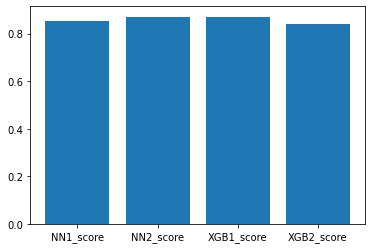

In [52]:
names = list(results.keys())
values = list(results.values())

plt.bar(range(len(results)), values, tick_label=names)
plt.show()

In [50]:
# In this comparison a Neural Network with hyperparameters tuned performs better than the one with default values. However, 
# XGBClassifier with hyperparameters tuned performs worse than the one with default values. This might be a result of either 
# poorly chosen hyperparameters values or the small dataset.